# Importing Dependencies

In [1]:
import json
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

# Data Prep

In [2]:
with open('../output/rare-disease_monthly_desktop_201507-202409.json', 'r') as file:
    desktop = json.load(file)

with open('../output/rare-disease_monthly_mobile_201507-202409.json', 'r') as file:
    mobile = json.load(file)

with open('../output/rare-disease_monthly_cumulative_201507-202409.json', 'r') as file:
    cumulative = json.load(file)



In [3]:
def json_to_df(json_data):

    transformed_data = []

    for key, value in json_data.items():
        try:
            for item in value["items"]:
                item["id"] = key
                transformed_data.append(item)
        except:
            continue

    output_df = pd.json_normalize(transformed_data)

    return output_df

In [4]:
def parse_timestamps(df, timestamp_column = "timestamp"):
    datestring = df[timestamp_column].str[:4] + "-" + df[timestamp_column].str[4:6] + "-" + df[timestamp_column].str[6:8]
    df[timestamp_column] = pd.to_datetime(datestring)

    return df

In [5]:
desktop_df = json_to_df(desktop)
desktop_df = parse_timestamps(desktop_df)
desktop_df.set_index('timestamp', inplace=True)

In [6]:
mobile_df = json_to_df(mobile)
mobile_df = parse_timestamps(mobile_df)
mobile_df.set_index('timestamp', inplace=True)

In [7]:
cumulative_df = json_to_df(cumulative)
cumulative_df = parse_timestamps(cumulative_df)
cumulative_df.set_index('timestamp', inplace=True)

# Maximum Average and Minimum Average

In [8]:
desktop_df_ = desktop_df[["id", "views"]]

avg_desktop_views = desktop_df_.groupby("id").mean().sort_values("views", ascending=False)

id_of_desktop_max = avg_desktop_views["views"].idxmax()

id_of_desktop_max

'Black Death'

In [9]:
id_of_desktop_min = avg_desktop_views["views"].idxmin()

id_of_desktop_min

'Filippi Syndrome'

In [10]:
avg_desktop_views

,views
id,
Black Death,104859.315315
Tuberculosis,71768.621622
Multiple sclerosis,57457.684685
Smallpox,55645.261261
Dopamine,48815.486486
...,...
Hypoplasminogenemia,11.027273
Primary anemia,9.162162
CDLS,8.135135


In [11]:
mobile_df_ = mobile_df[["id", "views"]]

avg_mobile_views = mobile_df_.groupby("id").mean().sort_values("views", ascending=False)

id_of_mobile_max = avg_mobile_views["views"].idxmax()

id_of_mobile_min = avg_mobile_views["views"].idxmin()

In [12]:
id_of_mobile_max

'Black Death'

In [13]:
id_of_mobile_min

'Filippi Syndrome'

In [14]:
avg_mobile_views

,views
id,
Black Death,177697.846847
Tuberculosis,155546.099099
Multiple sclerosis,122010.297297
Amyotrophic lateral sclerosis,101279.243243
Leprosy,94630.018018
...,...
Hypoplasminogenemia,5.872727
XPG N terminus,4.486486
18p,3.081081


In [15]:
mobile_desktop_df = pd.concat([desktop_df, mobile_df])

In [16]:
df_for_graph1 = mobile_desktop_df[(mobile_desktop_df["id"] == id_of_desktop_max) | 
                                      (mobile_desktop_df["id"] == id_of_desktop_min) |
                                      (mobile_desktop_df["id"] == id_of_mobile_max) | 
                                      (mobile_desktop_df["id"] == id_of_mobile_min)
                                      ]

In [17]:
def label_series(df):
    if df["id"] == id_of_desktop_max and df["access"] == "desktop":
        return "Desktop Max: " + df["id"]
    if df["id"] == id_of_desktop_min and df["access"] == "desktop":
        return "Desktop Min: " + df["id"]
    if df["id"] == id_of_mobile_max and pd.isna(df["access"]):
        return "Mobile Max: " + df["id"]
    if df["id"] == id_of_mobile_min and pd.isna(df["access"]):
        return "Mobile Min: " + df["id"]
    
df_for_graph1["label"] = df_for_graph1.apply(label_series, axis = 1)

/var/folders/4b/m5nrgw957519qfykv2lpzg_80000gp/T/ipykernel_7514/2034262532.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_graph1["label"] = df_for_graph1.apply(label_series, axis = 1)


In [18]:
df_for_graph1

,project,article,granularity,access,agent,views,id,label
timestamp,,,,,,,,
2021-12-01,en.wikipedia,Filippi_Syndrome,monthly,desktop,user,20,Filippi Syndrome,Desktop Min: Filippi Syndrome
2022-01-01,en.wikipedia,Filippi_Syndrome,monthly,desktop,user,10,Filippi Syndrome,Desktop Min: Filippi Syndrome
2022-02-01,en.wikipedia,Filippi_Syndrome,monthly,desktop,user,12,Filippi Syndrome,Desktop Min: Filippi Syndrome
2022-03-01,en.wikipedia,Filippi_Syndrome,monthly,desktop,user,46,Filippi Syndrome,Desktop Min: Filippi Syndrome
2022-04-01,en.wikipedia,Filippi_Syndrome,monthly,desktop,user,11,Filippi Syndrome,Desktop Min: Filippi Syndrome
...,...,...,...,...,...,...,...,...
2024-05-01,en.wikipedia,Black_Death,monthly,NaN,user,107363,Black Death,Mobile Max: Black Death
2024-06-01,en.wikipedia,Black_Death,monthly,NaN,user,99637,Black Death,Mobile Max: Black Death
2024-07-01,en.wikipedia,Black_Death,monthly,NaN,user,141835,Black Death,Mobile Max: Black Death


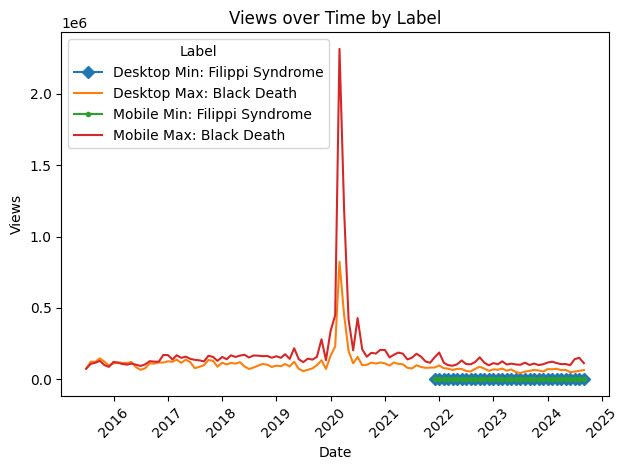

In [19]:
# Mobile and desktop min are difficult to distinguish at this scale, so I customize the
# line styles to make both show up
shapes = ["D", "", ".", ""]
linestyles = ["-", "-", "-", "-"]

for i, label in enumerate(df_for_graph1["label"].unique()):
    plt.plot(
        df_for_graph1[df_for_graph1["label"] == label].index,
        df_for_graph1[df_for_graph1["label"] == label]["views"],
        label = label,
        marker = shapes[i],
        linestyle = linestyles[i]
    )

plt.title('Views over Time by Label')
plt.xlabel('Date')
plt.ylabel('Views')
plt.legend(title='Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Top 10 Peak Page Views

In [70]:
mobile_desktop_df_ = mobile_desktop_df[["article", "access", "views"]]
mobile_desktop_df_.loc[:, "access"].fillna("mobile", inplace=True)

sorted_mobile_desktop = mobile_desktop_df_.groupby(["article", "access"]).max().sort_values("views", ascending=False).reset_index()

sorted_mobile_desktop.rename(columns={"views" : "peak_views"}, inplace=True)

/var/folders/4b/m5nrgw957519qfykv2lpzg_80000gp/T/ipykernel_7514/3718196639.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mobile_desktop_df_.loc[:, "access"].fillna("mobile", inplace=True)
/var/folders/4b/m5nrgw957519qfykv2lpzg_80000gp/T/ipykernel_7514/3718196639.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mobile_desktop_df_.loc[:

In [71]:
sorted_mobile_desktop

,article,access,peak_views
0,Black_Death,mobile,2313741
1,Pandemic,mobile,2276916
2,Pandemic,desktop,1046521
3,Black_Death,desktop,823649
4,Pfeiffer_syndrome,mobile,777886
...,...,...,...
3535,Joseph_Vinetz,mobile,30
3536,Project_Nicaragua,mobile,25
3537,HOXA6,mobile,22
3538,Filippi_Syndrome,mobile,11


In [78]:
mobile_peak = sorted_mobile_desktop[sorted_mobile_desktop["access"] == "mobile"].head(10)
mobile_peak_articles = set(mobile_peak["article"])

mobile_peak_articles

{'Black_Death',
 'Botulism',
 'Chloroquine',
 'Cleidocranial_dysostosis',
 'Glioblastoma',
 'Kawasaki_disease',
 'Pandemic',
 'Pfeiffer_syndrome',
 'Porphyria',
 'Stiff-person_syndrome'}

In [79]:
desktop_peak = sorted_mobile_desktop[sorted_mobile_desktop["access"] == "desktop"].head(10)
desktop_peak_articles = set(desktop_peak["article"])

desktop_peak_articles

{'Amyotrophic_lateral_sclerosis',
 'Black_Death',
 'Botulism',
 'Chloroquine',
 'Cleidocranial_dysostosis',
 'Fibrodysplasia_ossificans_progressiva',
 'Pandemic',
 'Pfeiffer_syndrome',
 'Robert_Koch',
 'Smallpox'}

In [80]:
df_for_graph2 = mobile_desktop_df_[((mobile_desktop_df_["article"].isin(mobile_peak_articles)) & 
                                    (mobile_desktop_df_["access"] == "mobile")) |
                                    ((mobile_desktop_df_["article"].isin(desktop_peak_articles)) &
                                     (mobile_desktop_df_["access"] == "desktop"))]

In [81]:
df_for_graph2

,article,access,views
timestamp,,,
2015-07-01,Pandemic,desktop,14291
2015-08-01,Pandemic,desktop,15232
2015-09-01,Pandemic,desktop,18668
2015-10-01,Pandemic,desktop,20499
2015-11-01,Pandemic,desktop,18930
...,...,...,...
2024-05-01,Botulism,mobile,46810
2024-06-01,Botulism,mobile,46597
2024-07-01,Botulism,mobile,41879


In [82]:
def label_series_graph2(row):
    
    if row["article"] in (mobile_peak_articles) and row["access"] == "mobile":
        return "Top 10 peak mobile article: " + row["article"]
    if row["article"] in (desktop_peak_articles) and row["access"] == "desktop":
        return "Top 10 peak desktop article: " + row["article"]


In [83]:
df_for_graph2.loc[:,"label"] = df_for_graph2.apply(label_series_graph2, axis = 1)

df_for_graph2

/var/folders/4b/m5nrgw957519qfykv2lpzg_80000gp/T/ipykernel_7514/963632166.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_graph2.loc[:,"label"] = df_for_graph2.apply(label_series_graph2, axis = 1)


,article,access,views,label
timestamp,,,,
2015-07-01,Pandemic,desktop,14291,Top 10 peak desktop article: Pandemic
2015-08-01,Pandemic,desktop,15232,Top 10 peak desktop article: Pandemic
2015-09-01,Pandemic,desktop,18668,Top 10 peak desktop article: Pandemic
2015-10-01,Pandemic,desktop,20499,Top 10 peak desktop article: Pandemic
2015-11-01,Pandemic,desktop,18930,Top 10 peak desktop article: Pandemic
...,...,...,...,...
2024-05-01,Botulism,mobile,46810,Top 10 peak mobile article: Botulism
2024-06-01,Botulism,mobile,46597,Top 10 peak mobile article: Botulism
2024-07-01,Botulism,mobile,41879,Top 10 peak mobile article: Botulism


AttributeError: Text.set() got an unexpected keyword argument 'loc'

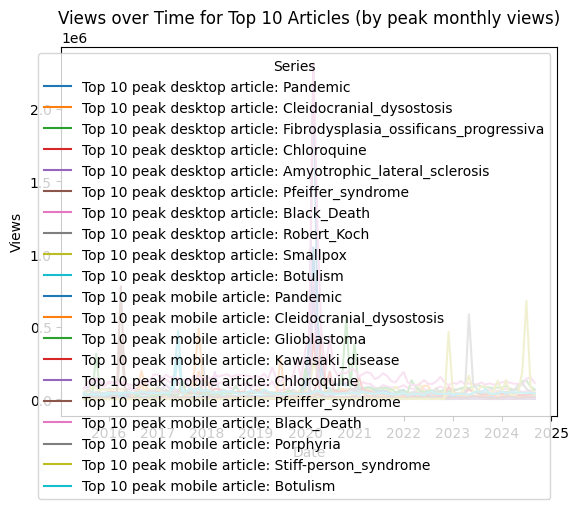

In [86]:
# for i, label in enumerate(df_for_graph1["label"].unique()):
#     plt.plot(
#         df_for_graph1[df_for_graph1["label"] == label].index,
#         df_for_graph1[df_for_graph1["label"] == label]["views"],
#         label = label,
#         marker = shapes[i],
#         linestyle = linestyles[i]
#     )

# # Customize the plot
# plt.title('Views over Time by Label')
# plt.xlabel('Date')
# plt.ylabel('Views')
# plt.legend(title='Label')
# plt.xticks(rotation=45)
# plt.tight_layout()

# plt.show()

for i, label in enumerate(df_for_graph2["label"].unique()):
    plt.plot(
        df_for_graph2[df_for_graph2["label"] == label].index,
        df_for_graph2[df_for_graph2["label"] == label]["views"],
        label = label,
    )

plt.title("Views over Time for Top 10 Articles (by peak monthly views)")
plt.xlabel("Date")
plt.ylabel("Views")
plt.legend(title = "Series", 
           loc = "lower center",
           bbox_to_anchor=(0.5, -0.1), 
           ncol=2)
plt.xticks(rotation = 45)
plt.tight_layout()